<a href="https://colab.research.google.com/github/CahyaPutera/AMAZON-FOOD-REVIEWS/blob/main/AmazonFood_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMAZON FINE FOOD REVIEWS

> In this notebook, I will try to demonstrate the **Latent Dirichlet Allocation Model (LDA)** for topic modelling using Gensim Package, and **pyLDAvis** to visualize the LDA topics. 

> The dataset used are from the **Amazon Fine Food Reviews** dataset : https://www.kaggle.com/snap/amazon-fine-food-reviews.

> Since the process on this notebook (especially the model training part) will take a rigorous amount of time to run only on a normal everyday CPU, I will be using google colab's TPU to accelerate the process a little bit and will only take the short reviews (about 40% of the total data), and further reduce the it, so in the end we only got 20% of the total filtered data, that is about 150 thousand data.

## PREPARATION

In [1]:
# insall spacy

!pip install spacy

In [2]:
# install english spacy model

!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [3]:
# install pyLDAvis

!pip install pyLDAvis

In [4]:
# install gensim

!pip install gensim

## IMPORT LIBRARIES

In [5]:
# integrate to google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# data wrangling

import re
import string
import pandas as pd
import numpy as np
import spacy

# data visualization

import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim

# text modelling 

import nltk
from nltk.corpus import stopwords
import en_core_web_sm
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

# filter warning

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## OVERVIEW

In [7]:
# load data

df = pd.read_csv('/content/drive/MyDrive/Reviews.csv', error_bad_lines=False, engine="python")

In [8]:
# show top 5

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
# check info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [10]:
# check for null values

df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

> Since the null values are not more than 1% of the total data, I will drop the null values.

## PREPROCESSING

In [11]:
# drop the null values

df.dropna(axis = 0, how ='any',inplace=True) 

In [12]:
# check info after dropping null

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568411 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568411 non-null  int64 
 1   ProductId               568411 non-null  object
 2   UserId                  568411 non-null  object
 3   ProfileName             568411 non-null  object
 4   HelpfulnessNumerator    568411 non-null  int64 
 5   HelpfulnessDenominator  568411 non-null  int64 
 6   Score                   568411 non-null  int64 
 7   Time                    568411 non-null  int64 
 8   Summary                 568411 non-null  object
 9   Text                    568411 non-null  object
dtypes: int64(5), object(5)
memory usage: 47.7+ MB


In [13]:
# check null values after dropping

df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [14]:
# download the stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# create function for case folding

def case_fold(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text = text.translate(table)
    textArr= text.split()
    text_clean = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text_clean.lower()

In [16]:
# apply casefolding and create number words feature

df['Text'] = df['Text'].apply(case_fold)
df['Num_words_text'] = df['Text'].apply(lambda x:len(str(x).split())) 

> Before going further, I will filter the data first so that the process might not take a long training time.

In [25]:
# filter the short reviews only

max_review_data_sentence_length = df['Num_words_text'].max()

mask = (df['Num_words_text'] >=20) & (df['Num_words_text'] < 100)
df_short_reviews = df[mask]
df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))

No of Short reviews
373281


In [33]:
# replace original dataframe

df = df_short_reviews

# further reduce the dataframe (take only 150000 data)

df = df[:150000].reset_index(drop='index')

In [34]:
# show top 5 data

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Num_words_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,have bought several vitality canned food produ...,30
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanutsth...,20
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this confection that been around centuries lig...,52
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,looking secret ingredient robitussin believe h...,22
4,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,wild hair taffy ordered this five pound taffy ...,43


In [35]:
# show info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      150000 non-null  int64 
 1   ProductId               150000 non-null  object
 2   UserId                  150000 non-null  object
 3   ProfileName             150000 non-null  object
 4   HelpfulnessNumerator    150000 non-null  int64 
 5   HelpfulnessDenominator  150000 non-null  int64 
 6   Score                   150000 non-null  int64 
 7   Time                    150000 non-null  int64 
 8   Summary                 150000 non-null  object
 9   Text                    150000 non-null  object
 10  Num_words_text          150000 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 12.6+ MB


> Now that the data is properly filtered, I'll continue the process.

In [36]:
# function to remove stopwords

def remove_stopwords(text):
    textArr = text.split(' ')
    stop_clean = " ".join([i for i in textArr if i not in stop_words])
    return stop_clean

In [37]:
# remove stopwords from the cleaned text

stop_words = stopwords.words('english')

df['Text'] = df['Text'].apply(remove_stopwords)

In [38]:
# load spacymodel for lemmatization

nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [39]:
# function to lemmatize text

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
    output = []
    for sent in texts:
        doc = nlp(sent) 
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
    return output

In [40]:
# apply lemmatization

text_list = df['Text'].tolist()
tokenized_reviews = lemmatization(text_list)

> I'll show the difference between the before and after lemmatization process.

In [41]:
# before lemma

print(text_list[2])

confection around centuries light pillowy citrus gelatin nuts case filberts tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch


In [42]:
# after lemma

print(tokenized_reviews[2])

['confection', 'century', 'pillowy', 'case', 'tiny', 'square', 'powdered', 'sugar', 'tiny', 'chewy', 'yummy', 'treat', 'familiar', 'story', 'seduce', 'selling', 'brother', 'sister']


## MODELLING

> Now, I'll create vocabulary dictionary and document term matrix.

In [43]:
# create dict and document matrix

dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

> I'll start to build the model using LDA.

In [44]:
# Creating the object for LDA model using gensim library

LDA = gensim.models.ldamodel.LdaModel

In [45]:
# Build LDA model

lda_model = LDA(corpus = doc_term_matrix, id2word = dictionary, num_topics = 6, 
                random_state = 100, chunksize = 100, passes = 20)

In [46]:
# print topics

lda_model.print_topics()

[(0,
  '0.036*"sugar" + 0.027*"treat" + 0.021*"bottle" + 0.017*"amount" + 0.015*"small" + 0.013*"sweet" + 0.013*"syrup" + 0.012*"hard" + 0.012*"money" + 0.012*"candy"'),
 (1,
  '0.038*"chocolate" + 0.037*"flavor" + 0.034*"good" + 0.026*"taste" + 0.022*"snack" + 0.021*"great" + 0.019*"milk" + 0.018*"sweet" + 0.017*"chip" + 0.016*"little"'),
 (2,
  '0.070*"product" + 0.030*"great" + 0.021*"good" + 0.019*"free" + 0.017*"time" + 0.016*"price" + 0.016*"whole" + 0.012*"kid" + 0.011*"year" + 0.011*"family"'),
 (3,
  '0.058*"water" + 0.050*"taste" + 0.048*"flavor" + 0.019*"good" + 0.015*"star" + 0.014*"review" + 0.011*"coconut" + 0.010*"soup" + 0.009*"tea" + 0.009*"green"'),
 (4,
  '0.065*"food" + 0.034*"cereal" + 0.020*"product" + 0.015*"salt" + 0.015*"package" + 0.014*"healthy" + 0.013*"small" + 0.013*"dog" + 0.012*"month" + 0.012*"year"'),
 (5,
  '0.081*"coffee" + 0.043*"store" + 0.032*"good" + 0.023*"flavor" + 0.021*"price" + 0.018*"great" + 0.017*"local" + 0.015*"taste" + 0.014*"favorite"

## VISUALIZATION

> Now, I'll visualize the topics, but before that I'll measure the perplexity. **Perplexity** is a measure of how good the model is, the lower the better.

In [47]:
# visualize topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)

In [48]:
# print perplexity

print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000)) 


Perplexity:  -8.911059853716743


In [49]:
# show visualization

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.112250 -0.044336       1        1  20.974004
2     -0.191835 -0.079137       2        1  17.966543
4     -0.241733 -0.023222       3        1  17.296924
5      0.028784 -0.174194       4        1  16.277869
3      0.288236 -0.042907       5        1  14.040100
0      0.004297  0.363797       6        1  13.444561, topic_info=        Term          Freq         Total Category  logprob  loglift
184   coffee  36112.000000  36112.000000  Default  30.0000  30.0000
1       food  30726.000000  30726.000000  Default  29.0000  29.0000
5    product  43914.000000  43914.000000  Default  28.0000  28.0000
196    water  22340.000000  22340.000000  Default  27.0000  27.0000
42    flavor  50330.000000  50330.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
479     work   2436.173185   6023.777952   Topic6  -5.0212   1.1013
109   review   2596.799722   8142.862184   Topic6  -4.9574   0.8637
120     time   3207.804522  22451.809095   Topic6  -4.7461   0.0608
106     full   2282.044207   4707.496496   Topic6  -5.0866   1.2825
2       good   2296.944121  59048.205254   Topic6  -5.0801  -1.2402

[320 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
162       1  0.999740         able
1098      3  0.999751       almond
698       2  0.999766  alternative
499       5  0.999628      amazing
613       1  0.999748       amazon
...     ...       ...          ...
479       6  0.404397         work
145       6  0.998979        world
113       2  0.380214         year
113       3  0.378554         year
113       4  0.241238         year

[382 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 6, 4, 1])

In [50]:
# compute the coherence score

coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

> Next, I'll show the baseline **Coherence Score**. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

In [58]:
# print coherence score

print('\nBase Coherence Score: ', coherence_lda)


Base Coherence Score:  0.33753198858961736


In [52]:
# function to compute coherence values

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [54]:
# compute the coherence values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=15, step=1)

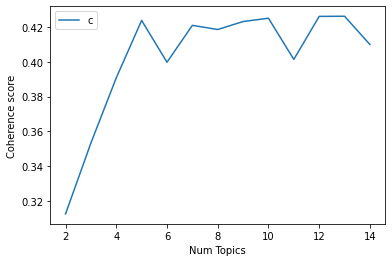

In [55]:
# show graph

limit=15; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


> As we can see with the coherence score seems to keep increasing with the number of topics, it may make better sense to pick the model that gave the highest CV before flattening out or a major drop. In this case is 9.

In [56]:
# print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3127
Num Topics = 3  has Coherence Value of 0.3534
Num Topics = 4  has Coherence Value of 0.3908
Num Topics = 5  has Coherence Value of 0.4237
Num Topics = 6  has Coherence Value of 0.3997
Num Topics = 7  has Coherence Value of 0.4209
Num Topics = 8  has Coherence Value of 0.4185
Num Topics = 9  has Coherence Value of 0.423
Num Topics = 10  has Coherence Value of 0.425
Num Topics = 11  has Coherence Value of 0.4013
Num Topics = 12  has Coherence Value of 0.426
Num Topics = 13  has Coherence Value of 0.4261
Num Topics = 14  has Coherence Value of 0.4099


> Since we want the amount number of 9, I would pick the index number 7 on the *model_list*.

In [61]:
# select model and print the topics

optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)

In [62]:
# print optimal topics

optimal_model.print_topics(num_words=10)

[(0,
  '0.021*"bread" + 0.020*"sauce" + 0.014*"good" + 0.012*"chicken" + 0.012*"easy" + 0.012*"time" + 0.012*"recipe" + 0.012*"minute" + 0.011*"little" + 0.010*"meat"'),
 (1,
  '0.035*"butter" + 0.024*"peanut" + 0.022*"product" + 0.013*"free" + 0.011*"seed" + 0.010*"ground" + 0.010*"pretzel" + 0.009*"year" + 0.009*"biscuit" + 0.008*"sick"'),
 (2,
  '0.037*"product" + 0.023*"time" + 0.023*"order" + 0.015*"package" + 0.015*"good" + 0.015*"great" + 0.013*"bag" + 0.011*"item" + 0.010*"month" + 0.010*"cookie"'),
 (3,
  '0.085*"food" + 0.031*"treat" + 0.020*"dog" + 0.015*"cat" + 0.015*"good" + 0.014*"product" + 0.012*"great" + 0.012*"love" + 0.011*"year" + 0.011*"small"'),
 (4,
  '0.046*"store" + 0.040*"price" + 0.034*"product" + 0.023*"good" + 0.020*"local" + 0.017*"great" + 0.014*"grocery" + 0.013*"brand" + 0.012*"year" + 0.011*"time"'),
 (5,
  '0.031*"chip" + 0.031*"good" + 0.027*"flavor" + 0.022*"salt" + 0.022*"great" + 0.021*"snack" + 0.019*"taste" + 0.012*"healthy" + 0.011*"love" + 0.0

In [63]:
# visualize the optimal topics

pyLDAvis.enable_notebook()
vis_opt = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)

In [64]:
# show visualization of optimal topics

vis_opt

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.153292  0.023694       1        1  17.289560
4      0.123117  0.154181       2        1  13.775324
3      0.079087  0.011973       3        1  13.751272
8     -0.156531  0.079430       4        1  11.947403
5     -0.109399  0.002661       5        1  11.065416
2      0.169887  0.176151       6        1  10.091179
6     -0.140086 -0.097616       7        1   8.730331
0     -0.026005 -0.115187       8        1   7.957589
1      0.213223 -0.235287       9        1   5.391925, topic_info=          Term          Freq         Total Category  logprob  loglift
184     coffee  39300.000000  39300.000000  Default  30.0000  30.0000
1         food  34257.000000  34257.000000  Default  29.0000  29.0000
234      store  17579.000000  17579.000000  Default  28.0000  28.0000
196      water  17289.000000  17289.000000  Default  27.0000  27.0000
171  chocolate  15228.000000  15228.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
2         good    867.162581  59934.370277   Topic9  -5.1405  -1.3155
479       work    634.992751   5943.969186   Topic9  -5.4521   0.6837
343    problem    618.750921   6981.167394   Topic9  -5.4780   0.4970
633     people    535.139839   5868.707464   Topic9  -5.6232   0.5254
410    natural    522.428533   6480.427775   Topic9  -5.6472   0.4022

[632 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1705      7  0.998412   absolute
480       5  0.036339   additive
480       7  0.959690   additive
480       8  0.003304   additive
3977      1  0.029270     advice
...     ...       ...        ...
113       9  0.094517       year
2017      2  0.004812      yeast
2017      8  0.959138      yeast
2017      9  0.033682      yeast
4648      1  0.996615  yesterday

[1623 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 4, 9, 6, 3, 7, 1, 2])

> References : 
> - https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

> Method to find optimal number of topics
code : 
> - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

> More on visualization with pyLDAvis on : 
> - https://github.com/bmabey/pyLDAvis and 
> - https://speakerdeck.com/bmabey/visualizing-topic-models
